In [1]:
import warnings
warnings.filterwarnings('ignore')

# Origin-Destination Flow Maps

[Jeff Allen](http://jamaps.github.io)

April, 2023

<img src="images/calgary-hospital-map-multipes-python-export.png" width="1919">

Image

Hub-and-spoke maps or spider diagrams

## Prerequisites

Prior knowledge of pandas, geopandas, QGIS, and Inkscape (or similar graphic design software) would be helpful for the following tutorial.

Click [here](https://github.com/schoolofcities/mapping-workshops-2023/raw/main/notebooks/od-flow-maps/od-flow-maps.zip) to download this article as a Jupyter Notebook alongside the datasets required. In the download, there is also a standalone Python script, if you want to run the steps all-at-once or integrate with anything else you have brewing.

You can also run the notebook [Binder](https://mybinder.org/v2/gh/schoolofcities/mapping-workshops-2023/HEAD?urlpath=lab%2Ftree%2Fnotebooks%2Fod-flow-maps%2Fod-flow-maps.ipynb)

If you are running the notebook and/or script locally (generally recommended), you will need to use the following libraries. You'll have to install them (e.g. via `pip` or `conda`) if you do not have them installed already.

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Origin-Destination Matrices

Origin-Destination matrices encode many people travel from one set of locations (e.g. neighbourhoods) to another set of location (e.g. destinations). These are sometimes called *flow* or *trip* tables.

In urban geography application, this data often represents people travelling in the city, to or from specific types of places. But it can also be used to represent the transport or travel of other phenomena e.g. prduct, trade, wildlife, etc.

This data can be based on real observations e.g. from administrative data that includes visiting patients' addresses or a survey that asks about daily travel. The data can also be *simulated*, i.e. estimated, based on a model that predicts trips between locations.

The toy data that we are going to look at below is the latter, ersatz data of trips to hospitals in Calgary. Let's load it and take a look. The data have 3 columns; the first is the ID of a Census Dissemination Area (DA), the second is the ID of a hospital, and the third column is the number of visits from each DA to each hospital.

In [3]:
od = pd.read_csv("data/od-flows.csv")
od.tail(5)

,dauid,hospital_id,trips
8370,48062794,0,19.0
8371,48062794,1,41.0
8372,48062794,2,4.0
8373,48062794,3,0.0
8374,48062794,4,16.0


When working with data like this, it is sometimes the case that the data are available in a *wide* format, where the rows pertain to the origin (e.g. Dissemination Area) and the columns pertain to the destination (e.g. hospitals), instead of the *long* format shown above.

In pandas, it's super easy to `pivot` from long to wide.

In [4]:
od_wide = od.pivot_table(index='dauid', columns='hospital_id', values='trips')
od_wide.tail(5)

hospital_id,0,1,2,3,4
dauid,,,,,
48062790,39.0,49.0,7.0,0.0,31.0
48062791,37.0,3.0,11.0,0.0,15.0
48062792,25.0,2.0,9.0,0.0,11.0
48062793,0.0,0.0,0.0,0.0,0.0
48062794,19.0,41.0,4.0,0.0,16.0


Here's how to `melt` from wide to long if you need to.

In [5]:
od_wide.reset_index().melt(
    id_vars='dauid', 
    value_vars=[0,1,2,3,4], 
    var_name="hospital_id", 
    value_name="population"
).head(5)

,dauid,hospital_id,population
0,48060056,0,20.0
1,48060057,0,16.0
2,48060058,0,20.0
3,48060059,0,14.0
4,48060060,0,24.0


We also have location data for the centroids of Dissemination Areas (DAs) and the hospitals. Let's load these and quickly plot them to take a look:

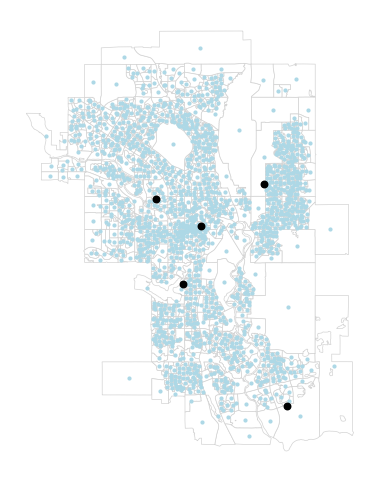

In [68]:
da = gpd.read_file("data/da-2021-centroids.geojson")
da_poly = gpd.read_file("data/da-2021-polygons.geojson")
hp = gpd.read_file("data/hospital-locations.geojson")

fig, ax = plt.subplots(figsize=(6,6))
da_poly.plot(
    ax = ax,
    edgecolor = 'LightGray',
    linewidth = 0.5,
    color = "White"
)
da.plot(
    ax = ax,
    color = 'LightBlue',
    markersize = 4
)
hp.plot(
    ax = ax,
    color = 'Black',
    markersize = 22
).set_axis_off()

For a flow map, we want to connect the two sets of points, and then style the lines based a weight connecting them, in this case number of trips between them.

For this, we are essentially creating a straight *line* geometry for every row in `od`. We can do this by first joining in the coordinates to the `od` flow matrix

In [7]:
da['dauid'] = da['name'].astype('int64')
odm = od.merge(
    da, 
    how='left', 
    on = "dauid"
).merge(
    hp, 
    how='left', 
    left_on='hospital_id',
    right_on='id'
)

Second, we use some [shapely](https://shapely.readthedocs.io/en/stable/index.html) magic to combine the two point geometries into a line geomery. We're also only keeping the other columns that we need for mapping.

In [8]:
odm = gpd.GeoDataFrame(
    {
        'dauid': odm['dauid'],
        'hospital_id': odm['hospital_id'],
        'trips': odm['trips'],
        'geometry': odm.apply(
            lambda x: LineString([x['geometry_x'], x['geometry_y']]), axis=1
        )
    }
).set_crs(epsg="4326")

# saving to file
odm.to_file("data/od-flow-lines.geojson", driver="GeoJSON")

Let's plot!

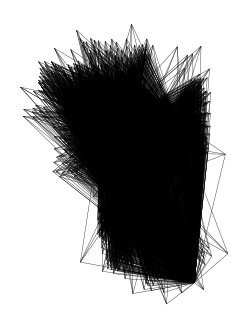

In [15]:
fig, ax = plt.subplots(figsize=(4,4))
odm.plot(
    ax = ax,
    linewidth = 0.25,
    color = 'Black'
).set_axis_off()

That's a bit of a mess, but it *looks like* the lines are all there. There are a few simple ways to distinguish lines with more trips, and dim those with fewer. The first is to have the line width be a function of the number of trips

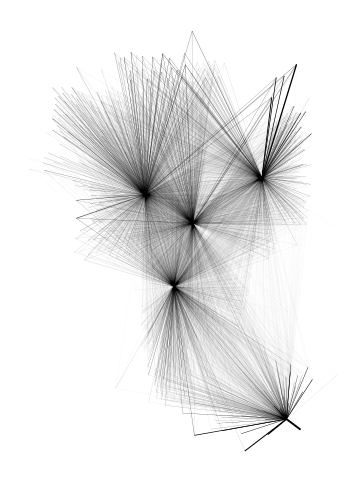

In [17]:
fig, ax = plt.subplots(figsize=(6,6))
odm.plot(
    ax = ax,
    linewidth = odm["trips"] / 1000,
    color = 'Black'
).set_axis_off()

We can also plot based on the function of the opacity of the line (i.e. less transparency if the connection has more trips). In the `plot` function, `alpha` controls the opacity, and ranges from 0 to 1. To normalize the `trips` column just by dividing by its max value.

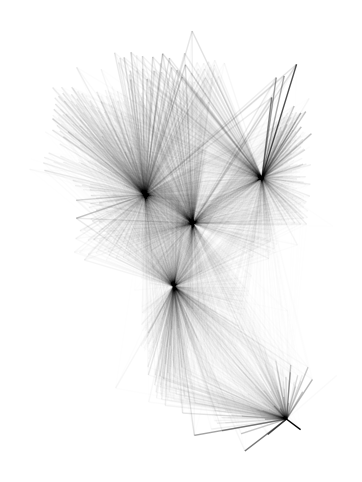

In [18]:
fig, ax = plt.subplots(figsize=(6,6))
odm.plot(
    ax = ax,
    linewidth = 1,
    alpha = odm['trips'] / odm['trips'].max(),
    color = 'Black'
).set_axis_off()

Let's try to better distinguish flows to each hospital, i.e. to approximately what the catchment is of visitors to each. We can do this via colour! Below we combine categorical colouring with dynamic opacity styling

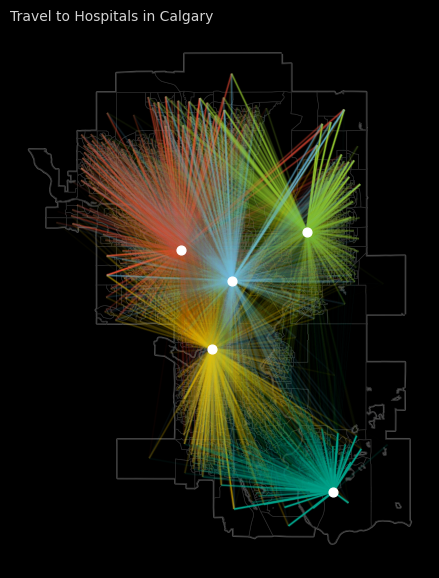

In [149]:
# specifying the colour and opacity of each line

colour_mapping = {
    0: "#DC4633",  
    1: "#8DBF2E",
    2: "#F1C500",
    3: "#00A189",
    4: "#6FC7EA",
}
odm["colour"] = odm["hospital_id"].map(colour_mapping)

odm["opacity"] = odm["trips"] / 250
odm['opacity'] = odm['opacity'].clip(upper=1)
                   
# plotting them all on a single plot!
    
fig, ax = plt.subplots(figsize=(7,7), facecolor='black')

da_poly.plot(
    ax = ax,
    edgecolor = '#484848',
    linewidth = 2,
    color = "Black"
)
da_poly.plot(
    ax = ax,
    edgecolor = '#2B2B2B',
    linewidth = 0.5,
    color = "Black"
)

for hospital in [0,1,2,3,4]:
    odp = odm[odm["hospital_id"] == hospital]
    odp.plot(
        ax=ax, 
        linewidth=1, 
        alpha=odp["opacity"], 
        color=odp['colour'], 
        zorder = 1
    )
    
for hospital in [0,1,2,3,4]:
    odp = odm[odm["hospital_id"] == hospital]
    odp.plot(
        ax=ax, 
        linewidth=2, 
        alpha=odp["opacity"] / 3, 
        color=odp['colour'], 
        zorder = 2
    )
    
hp.plot(
    ax = ax,
    color = 'White',
    markersize = 40,
    zorder = 3
)

ax.set_title(
    'Travel to Hospitals in Calgary', 
    fontsize=10,
    loc = "left"
).set_color('LightGray')

ax.set_axis_off()

fig.savefig('images/calgary-hospital-map-all-python-export.png')

The above map views nicely, but it can be a bit difficult to parse out travel to any specific hospital. One solution to this are small multiples, where we create 5 smaller plots, each focusing on a specific hospital.

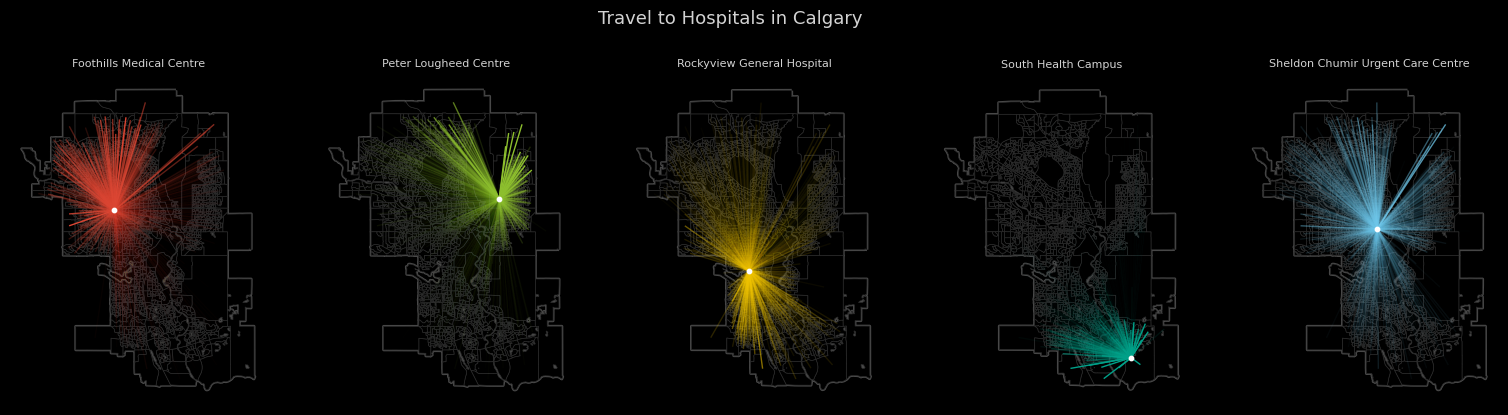

In [157]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(19.2,4.75), facecolor='black')

for hospital in [0,1,2,3,4]:
    
    # data layers
    
    odp = odm[odm["hospital_id"] == hospital]
    da_poly.plot(
        ax = ax[hospital],
        edgecolor = '#484848',
        linewidth = 2,
        color = "Black"
    )
    da_poly.plot(
        ax = ax[hospital],
        edgecolor = '#2B2B2B',
        linewidth = 0.5,
        color = "Black"
    )
    odp.plot(
        ax=ax[hospital], 
        linewidth=1, 
        alpha=odp["opacity"], 
        color=odp['colour'], 
        zorder = 1
    )
    hp[hp["id"] == hospital].plot(
        ax = ax[hospital],
        color = 'White',
        markersize = 10,
        zorder = 3
    ).set_axis_off()
    
    # titles
    
    ax[hospital].set_title(
        hp.loc[hospital, 'facility_name'], 
        fontsize=8,
        loc='center'
    ).set_color('LightGray')

# overall title and save to file
    
fig.suptitle(
    'Travel to Hospitals in Calgary', 
    fontsize=13
).set_color('LightGray')

fig.savefig('images/calgary-hospital-map-multipes-python-export.png')